# Лабораторная № 1 по предмету "Нейронные сети" 
Выполнена Якушевым Георгием, гр. 8307

In [4]:
# подгружаем необходимые модули
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from google.colab import drive

In [5]:
drive.mount("/content/drive/", force_remount=True) # Цепляем гугл-диск с датасетом

Mounted at /content/drive/


In [7]:
%cd '/content/drive/My Drive/EgorDataset'

/content/drive/My Drive/EgorDataset


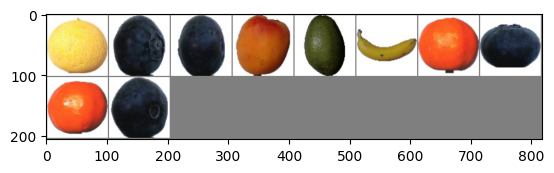

Cantaloupe Blueberry Blueberry Apricot Avocado Banana Clementine Blueberry Clementine Blueberry


In [9]:
transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]) # Задаем параметры для преобразований в тензоры
train_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/EgorDataset/train', transform=transform) # формируем датасет для обучения
test_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/EgorDataset/test', transform=transform) # формируем датасет для валидации

batch_size = 10

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cantaloupe', 'Cherry', 'Clementine')

###
# Важно! . Гугл диск видит файлы и папки в алфавитном порядке!
#поэтому классы перечислены в алфавитном порядке соответственно!
###

# функция для показа изображения
def imshow(img):
    img = img  / 2  + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# получаем несколько случайных обучающих изображений
dataiter = iter(trainloader)
images, labels = next(dataiter)

# показать изображения
imshow(torchvision.utils.make_grid(images))
# показать лейблы изображений
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Задаем архитектуры моделей

## Архитектура № 1

In [28]:
# Инициализация модели
class First_CNN(nn.Module):
    def __init__(self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    # Это forward функция, которая определяет структуру сети.
    # Здесь мы принимаем только один вход, но можно использовать больше.
    def forward(self, x):
        #print('started',x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print('after conv1',x.shape)
        x = self.pool(F.relu(self.conv2(x)))
       # print('after conv2',x.shape)
        x = self.pool(F.relu(self.conv3(x)))
       # print('after conv3',x.shape)
        x = torch.flatten(x, 1) #(input, start_dim) Сглаживает input путем преобразования его в одномерный тензор.
       # print('after flatten',x.shape)
        x = F.relu(self.fc1(x))
       # print('after fc1',x.shape)
        x = F.relu(self.fc2(x))
       # print('after fc2',x.shape)
        x = self.fc3(x)
        return x

net = First_CNN()

In [29]:
# Define the transforms for the training and testing sets
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and testing datasets
trainset = torchvision.datasets.ImageFolder(root='./train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.ImageFolder(root='./test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Initialize the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model
# На 8й и 7ой эпохах до этого происходит переобучение, поэтому выставляем 7 эпох.
# После двух наугад было решено поставить критерий остановы при 0.002 и меньше
# Переобучилась даже на 5. Ставим 3
for epoch in range(3):  # loop over the dataset multiple times


    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0


[1,   100] loss: 1.947
[1,   200] loss: 1.942
[1,   300] loss: 1.929
[1,   400] loss: 1.883
[1,   500] loss: 1.225
[1,   600] loss: 0.347
[2,   100] loss: 0.137
[2,   200] loss: 0.520
[2,   300] loss: 0.528
[2,   400] loss: 0.428
[2,   500] loss: 0.120
[2,   600] loss: 0.101
[3,   100] loss: 0.227
[3,   200] loss: 0.191
[3,   300] loss: 0.084
[3,   400] loss: 0.060
[3,   500] loss: 0.098
[3,   600] loss: 0.028


In [30]:
#Сохранение нашей модели
PATH = './first_net.pth'
torch.save(net.state_dict(), PATH)

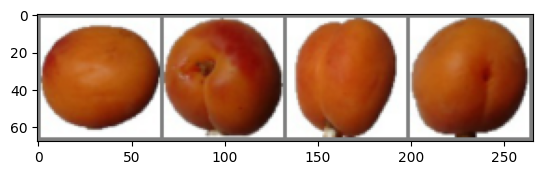

GroundTruth:  Apricot Apricot Apricot Apricot
Accuracy of the network on the 800 test images: 98 %


In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# вывод изображений
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = Net()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(images)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 800 test images: {100 * correct // total} %')

In [32]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Apricot is 100.0 %
Accuracy for class: Avocado is 89.5 %
Accuracy for class: Banana is 100.0 %
Accuracy for class: Blueberry is 100.0 %
Accuracy for class: Cantaloupe is 100.0 %
Accuracy for class: Cherry is 100.0 %
Accuracy for class: Clementine is 100.0 %


## Архитектура № 2

In [40]:
import seaborn as sns
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,6,5,padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer1=nn.Linear(3136,480)
        self.fc_layer2=nn.Linear(480,84)
        self.fc_layer3=nn.Linear(84,7)
        
        self.relu=nn.ReLU()
        
        #self.dropout1=nn.Dropout2d(0.2)
        #self.dropout2=nn.Dropout2d(0.5)
        
    def forward(self, x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=torch.flatten(x,1)
        x=self.fc_layer1(x)
        #x=self.dropout1(x)
        x=self.relu(x)
        x=self.fc_layer2(x)
        #x=self.dropout2(x)
        x=self.relu(x)
        #x=self.dropout2(x)
        x=self.fc_layer3(x)
        x=F.log_softmax(x,dim=1)
        return x    

net = LeNet5()

In [41]:
# Define the transforms for the training and testing sets
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and testing datasets
trainset = torchvision.datasets.ImageFolder(root='./train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.ImageFolder(root='./test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Initialize the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,   100] loss: 1.334
[1,   200] loss: 0.612
[1,   300] loss: 0.236
[1,   400] loss: 0.224
[1,   500] loss: 0.131
[1,   600] loss: 0.089
[2,   100] loss: 0.025
[2,   200] loss: 0.018
[2,   300] loss: 0.019
[2,   400] loss: 0.017
[2,   500] loss: 0.010
[2,   600] loss: 0.010
[3,   100] loss: 0.015
[3,   200] loss: 0.005
[3,   300] loss: 0.026
[3,   400] loss: 0.004
[3,   500] loss: 0.010
[3,   600] loss: 0.018


In [42]:
#Сохранение нашей модели
PATH = './first_net.pth'
torch.save(net.state_dict(), PATH)

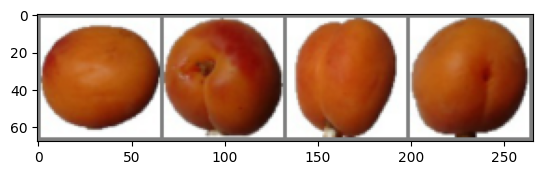

GroundTruth:  Apricot Apricot Apricot Apricot
Accuracy of the network on the 800 test images: 99 %


In [44]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# вывод изображений
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = LeNet5()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
# поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # рассчитываем выходные данные, пропуская изображения через сеть
        outputs = net(images)
        # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 800 test images: {100 * correct // total} %')

In [45]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # собираем правильные прогнозы для каждого класса
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# Выводим точность на каждом классе
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Apricot is 100.0 %
Accuracy for class: Avocado is 100.0 %
Accuracy for class: Banana is 100.0 %
Accuracy for class: Blueberry is 100.0 %
Accuracy for class: Cantaloupe is 100.0 %
Accuracy for class: Cherry is 100.0 %
Accuracy for class: Clementine is 97.6 %


## Архитектура № 3 и другой способ обучения и валидации

In [144]:
class Mixed_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(24,48,5),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(48,18,5),
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        
        self.fc_layer1=nn.Linear(450,120)
        self.fc_layer2=nn.Linear(120,22)
        self.fc_layer3=nn.Linear(22,7)
        
        self.relu=nn.ReLU()
        
        #self.dropout1=nn.Dropout2d(0.2)
        #self.dropout2=nn.Dropout2d(0.5)
        
    def forward(self, x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=self.conv_block3(x)
        x=torch.flatten(x,1)
        x=self.fc_layer1(x)
        #x=self.dropout1(x)
        x=self.relu(x)
        x=self.fc_layer2(x)
        #x=self.dropout2(x)
        x=self.relu(x)
        #x=self.dropout2(x)
        x=self.fc_layer3(x)
        x=F.log_softmax(x,dim=1)
        return x   

In [46]:
!pip install pytorch.ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 5.6 MB/s eta 0:00:00


In [136]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [145]:
# Define the transforms for the training and testing sets
train_transforms = transforms.Compose([
    transforms.Resize(64),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training and testing datasets
trainset = torchvision.datasets.ImageFolder(root='./train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.ImageFolder(root='./test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [146]:
model=Mixed_CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
# Число эпох
epochs = 100
# Движки trainer, evaluator
trainer = create_supervised_trainer(model, optimizer, criterion)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=7)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics)
test_evaluator = create_supervised_evaluator(model, metrics=metrics)
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [147]:
def score_function(engine):
    test_loss = engine.state.metrics['nll']
    return -test_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
test_evaluator.add_event_handler(Events.COMPLETED, handler)
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(trainloader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_test_results(trainer):
    test_evaluator.run(testloader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_test_results)

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(testloader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cantaloupe', 'Cherry', 'Clementine']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

to_save = {'model': model}
handler = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, handler)

profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

trainer.run(trainloader, max_epochs=epochs)


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 100.00 Сред. ошибка: 0.02
Результат валидации - Эпоха: 1  Сред. точность: 100.00 Сред. ошибка: 0.02


  2%|2         | 1/44 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 100.00 Сред. ошибка: 0.00
Результат валидации - Эпоха: 2  Сред. точность: 100.00 Сред. ошибка: 0.00


  2%|2         | 1/44 [00:00<?, ?it/s]

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


State:
	iteration: 100
	epoch: 3
	epoch_length: 44
	max_epochs: 100
	output: <class 'NoneType'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

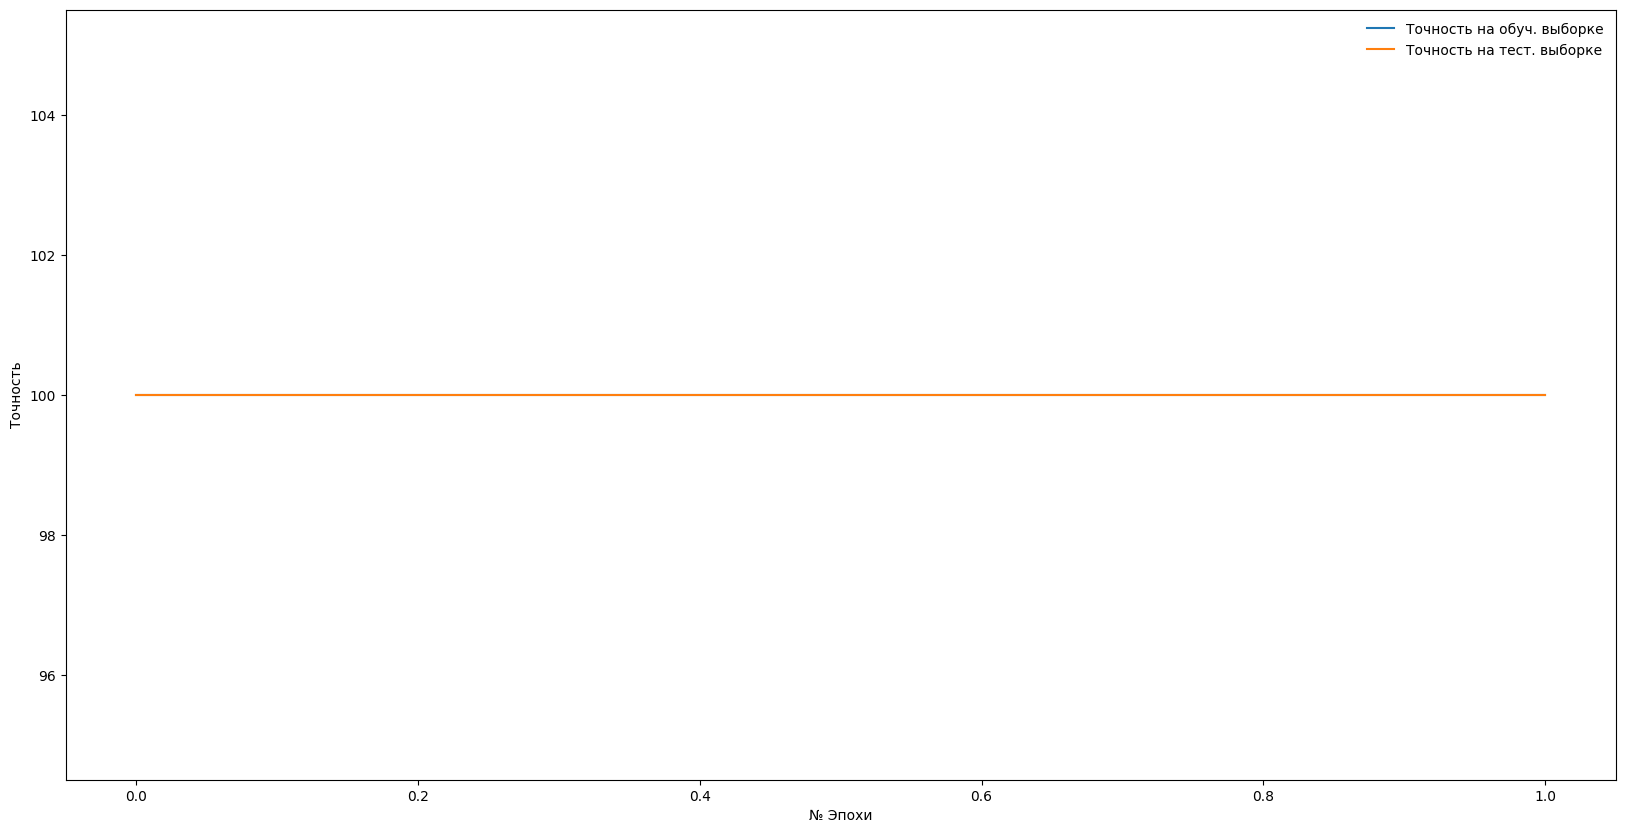

In [148]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

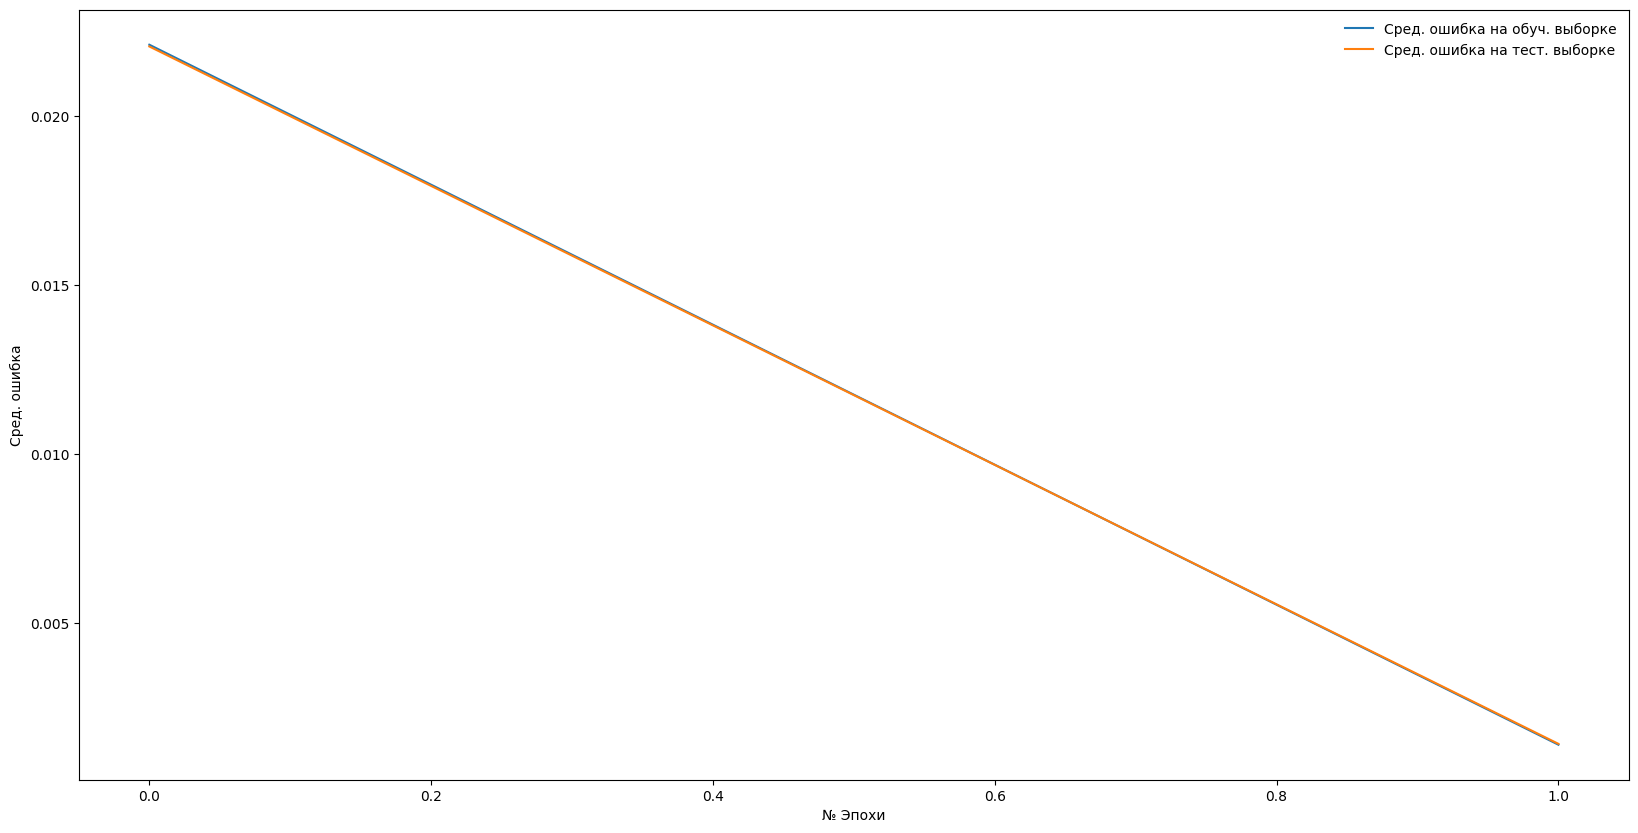

In [149]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()